# Parallelization Tutorial

`osier` is the first multi- and many-objective energy system optimization
platform. This notebook offers a guide to parallelization with `osier`.

You can run this notebook in interactive mode with Binder by clicking the badge below.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/samgdotson/osier/env-instructions?labpath=docs%2Fsource%2Fexamples%2Fparallelization_tutorial.ipynb)

In [3]:
# basic imports
import matplotlib.pyplot as plt
import numpy as np
from unyt import MW, GW, km

# osier imports
from osier import CapacityExpansion
from osier.tech_library import nuclear_adv, wind, battery, natural_gas
from osier import total_cost, annual_emission

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.pcp import PCP

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

## Preparing input data

Users only need to supply relevant timeseries data to `osier`.

In [14]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand 
wind_speed = np.random.weibull(a=2.5,size=N)

## Set up the problem

`osier` comes pre-loaded with technology data from the `osier.tech_library`. Users simply need to pass the data to a `CapacityExpansion` problem and run it using a `pymoo.minimize` runner.

In [18]:
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission],
                            model_engine='logical',
                            solver='appsi_highs')

In [19]:
%%time
res = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      5 |             - |             -
     2 |       40 |     10 |  0.0900438922 |         nadir
     3 |       60 |     12 |  0.0865541462 |         ideal
     4 |       80 |     13 |  0.0628297417 |         ideal
     5 |      100 |     16 |  0.0075832178 |         ideal
     6 |      120 |     18 |  0.1945920416 |         nadir
     7 |      140 |     20 |  0.0574346489 |         ideal
     8 |      160 |     20 |  0.0452822361 |         ideal
     9 |      180 |     19 |  0.0457673861 |         nadir
    10 |      200 |     20 |  0.0339976358 |         nadir
CPU times: user 4min 42s, sys: 2.1 s, total: 4min 44s
Wall time: 4min 46s


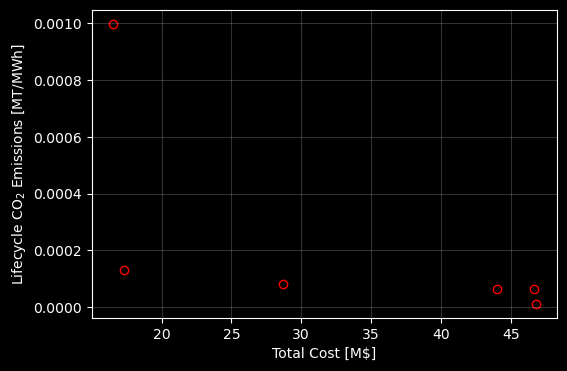

In [12]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()

/var/folders/6h/g412p7x53jbcqr_x5sy9z8th0000gn/T/ipykernel_92122/1527621391.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(res.X,


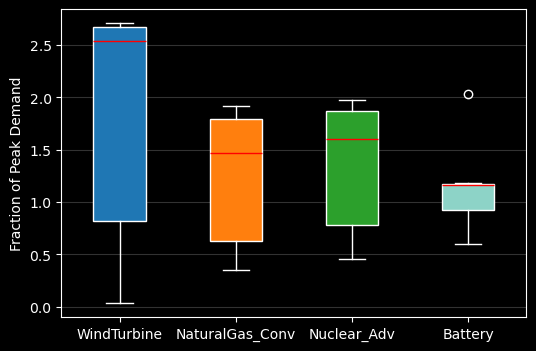

In [13]:
from osier import get_tech_names
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()

## Threads

In [10]:
# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission],
                            model_engine='lp',
                            solver='appsi_highs',
                            elementwise_runner=runner)

Exception ignored in: <function capture_output.__del__ at 0x14a3d1c60>
Traceback (most recent call last):
  File "/Users/samdotson/miniforge3/envs/osier-test04/lib/python3.12/site-packages/pyomo/common/tee.py", line 208, in __del__
    self.__exit__(None, None, None)
  File "/Users/samdotson/miniforge3/envs/osier-test04/lib/python3.12/site-packages/pyomo/common/tee.py", line 196, in __exit__
    self.tee.__exit__(et, ev, tb)
  File "/Users/samdotson/miniforge3/envs/osier-test04/lib/python3.12/site-packages/pyomo/common/tee.py", line 430, in __exit__
    self.close(et is not None)
  File "/Users/samdotson/miniforge3/envs/osier-test04/lib/python3.12/site-packages/pyomo/common/tee.py", line 413, in close
    raise RuntimeError(
RuntimeError: TeeStream: deadlock observed joining reader threads
Exception ignored in: <function capture_output.__del__ at 0x14a3d1c60>
Traceback (most recent call last):
  File "/Users/samdotson/miniforge3/envs/osier-test04/lib/python3.12/site-packages/pyomo/comm

In [11]:
res = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)
print('Threads:', res.exec_time)

pool.close()

Running HiGHS 1.8.1 (git hash: 4a7f24a): Copyright (c) 2024 HiGHS under MIT licence terms


KeyboardInterrupt: 

In [8]:
import psutil

threads_count = psutil.cpu_count() / psutil.cpu_count(logical=False)

In [9]:
threads_count

2.0

## Create new objectives and modify technology data

`osier` allows users to modify the problem formulation on the fly. Both by adding new data fields to technologies or by creating a new objective.

Users can create new objectives for any quantifiable metric. Here we add a parameter called `land_use` to the modeled technologies.

In [8]:
nuclear_adv.land_use = 4.4*1e-3 * (km**2/GW)
natural_gas.land_use = 3.2*1e-3 * (km**2/GW)
wind.land_use = 12.3e3*1e-3 * (km**2/GW)
battery.land_use = 6.0*1e-3 * (km**2/GW)

Then, we create a function that calculates the total land use. The minimum required format is

```py
def objective(technology_list, solved_dispatch_model):
    # some calculation
    return objective
```

In [9]:
def land_use(technology_list, solved_dispatch_model):
    """
    Calculates land use intensity.
    """
    
    obj_value = np.array([t.capacity.to_value() * t.land_use for t in technology_list]).sum()
    
    return obj_value

Now, we re-initialize the problem with our new objective and updated technologies.

In [12]:
%%time
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission, land_use],
                            solver='cbc')

res1 = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |     11 |  0.0823881536 |         ideal
     3 |       60 |     18 |  0.0589579800 |         ideal
     4 |       80 |     20 |  0.0063982942 |         ideal
     5 |      100 |     20 |  0.0311724049 |         ideal
     6 |      120 |     20 |  0.0106202339 |         ideal
     7 |      140 |     20 |  0.0269553868 |         nadir
     8 |      160 |     20 |  0.0102049651 |         ideal
     9 |      180 |     20 |  0.1287526163 |         nadir
    10 |      200 |     20 |  0.0397818793 |         ideal
CPU times: user 4min 45s, sys: 12.2 s, total: 4min 57s
Wall time: 5min 10s


In [13]:
%%time
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission, land_use],
                            solver='appsi_highs')

res2 = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      6 |             - |             -
     2 |       40 |     11 |  0.0823881536 |         ideal
     3 |       60 |     18 |  0.0589579800 |         ideal
     4 |       80 |     20 |  0.0063982942 |         ideal
     5 |      100 |     20 |  0.0311724049 |         ideal
     6 |      120 |     20 |  0.0106202339 |         ideal
     7 |      140 |     20 |  0.0269553868 |         nadir
     8 |      160 |     20 |  0.0102049651 |         ideal
     9 |      180 |     20 |  0.1287526163 |         nadir
    10 |      200 |     20 |  0.0397818793 |         ideal
CPU times: user 4min 54s, sys: 3.38 s, total: 4min 58s
Wall time: 5min 4s


In [14]:
%%time
problem = CapacityExpansion(technology_list=[wind, natural_gas, nuclear_adv, battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound = 1/wind.capacity_credit,
                            objectives=[total_cost, annual_emission, land_use],
                            model_engine='logical',
                            solver='appsi_highs')

res3 = minimize(problem,
               NSGA2(pop_size=20),
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      7 |             - |             -
     2 |       40 |     10 |  0.1400175567 |         ideal
     3 |       60 |     16 |  0.1098694596 |         ideal
     4 |       80 |     20 |  0.1229353182 |         ideal
     5 |      100 |     20 |  0.0348904059 |             f
     6 |      120 |     20 |  0.0218664153 |         ideal
     7 |      140 |     20 |  0.0059155786 |         nadir
     8 |      160 |     20 |  0.0057877007 |         ideal
     9 |      180 |     20 |  0.0806871345 |         nadir
    10 |      200 |     20 |  0.0079582816 |         ideal
CPU times: user 3min, sys: 1.88 s, total: 3min 2s
Wall time: 3min 6s


## Visualization

Below are some example visualizations using the `pymoo` visualization module and `matplotlib`.

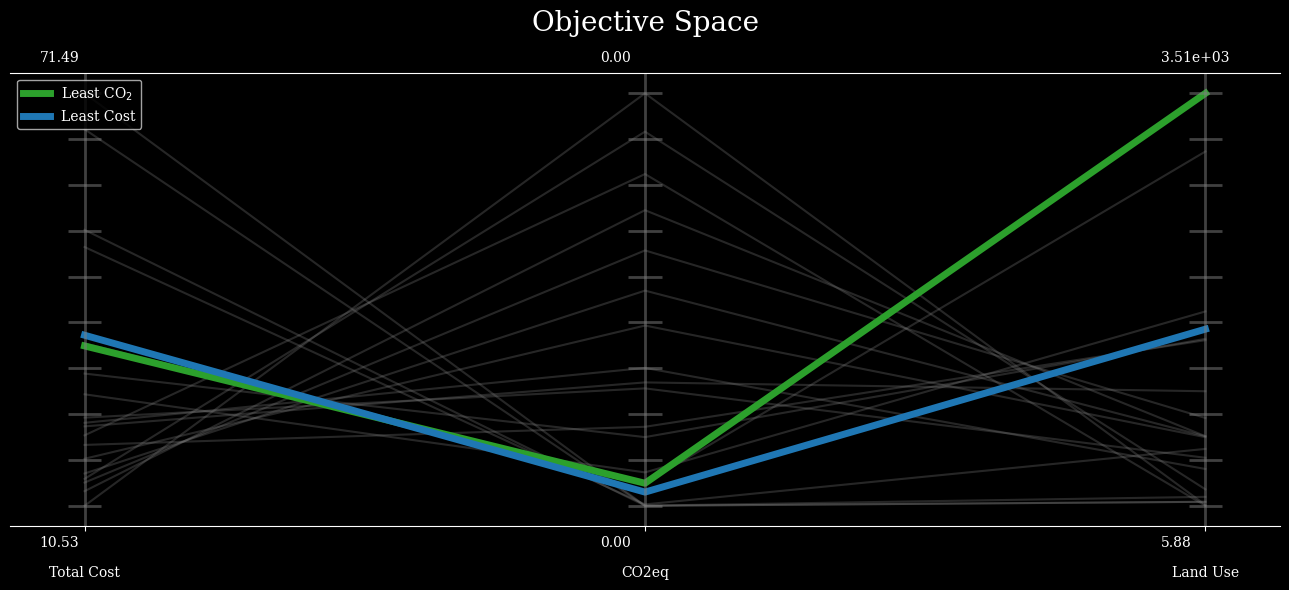

In [19]:
res = res1
obj_labels=['Total Cost', 'CO2eq', 'Land Use']
with plt.style.context('dark_background'):
    plot = PCP(title=("Objective Space", {'pad': 30, 'fontsize':20}),
            n_ticks=10,
            legend=(True, {'loc': "upper left"}),
            labels=obj_labels,
            figsize=(13,6),
            )

    plot.set_axis_style(color="grey", alpha=0.5)
    plot.tight_layout = True
    plot.add(res.F, color="grey", alpha=0.3)

    plot.add(res.F[3], linewidth=5, color="tab:green", label=r"Least CO$_2$")
    plot.add(res.F[6], linewidth=5, color="tab:blue", label="Least Cost")
    plot.show()
    plt.show()

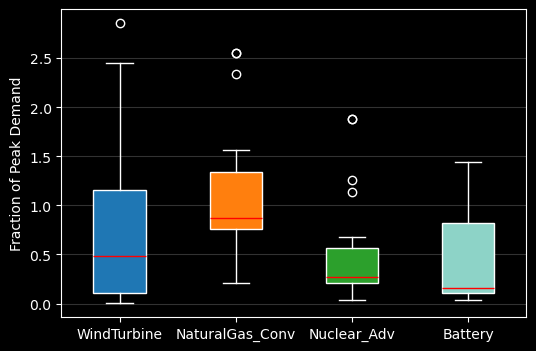

In [20]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    bplot = ax.boxplot(res.X,
                       patch_artist=True,
                       tick_labels=get_tech_names(problem.technology_list))
    ax.set_ylabel("Fraction of Peak Demand")

    # fill with colors
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    for median in bplot['medians']:
        median.set_color('red')

    ax.yaxis.grid(True, alpha=0.2)
    plt.show()